#Comparison of MIR Spectral Features with SED Luminosities

This notebook explores the relationship between the MIR spectral features measured from the Spitzer/IRS low-resolution spectra and the luminosities measured from the broadband SED's. Essentially if we've reasonably decomposed the SEDs into an AGN and star-forming component then we expect a nice correlation between the PAH features as well as NeII emission line and the FIR luminosity.

In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
import pickle
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'linmix/')
import linmix

In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
#bat_c12.loc['UGC06728', 'lir_sf'] += 2.0
#bat_c12.loc['UGC06728', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
#bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['bat_flux_err_low'] = bat_flux['BAT_flux'] - bat_flux['BAT_flux_90_low']
bat_flux['bat_flux_err_high'] = bat_flux['BAT_flux_90_high'] - bat_flux['BAT_flux']
bat_flux['lbat'] = np.log10(4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12))
bat_flux['bat_err'] = np.max(np.vstack([bat_flux['bat_flux_err_low'], bat_flux['bat_flux_err_high']]), axis=0)
bat_flux['lbat_err'] = 0.434*4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['bat_err']*10**(-12)/(10**bat_flux['lbat'])
bat_flux['lbat_flag'] = pd.Series(index=bat_flux.index)
bat_flux.loc[bat_flux['BAT_flux_90_high'] == 0, 'lbat_flag'] = 0
bat_flux.loc[bat_flux['BAT_flux_90_low'] != 0, 'lbat_flag'] = 1
bat_flux.loc[bat_flux['lbat_flag'] == 0, 'lbat_err'] = 0

In [4]:
# Upload the results from fitting the IRS spectra
f = open(gh_dir+'bat-agn-spitzer-irs-analysis/strengths_11-20-2015.pkl', 'rb')
strengths = pickle.load(f)
f.close()

In [5]:
# Extract the luminosities and equivalent widths for all of the features into Pandas DataFrames
df_lum = pd.DataFrame(columns=['PAH 11.3', 'PAH 11.3 err', 'PAH 7.7', 'PAH 7.7 err', 'PAH 6.2','PAH 6.2 err', 'NeII', 'NeII err', 'NeIII', 
                               'NeIII err', 'NeV', 'NeV err', 'OIV', 'OIV err'], index=strengths.keys(), dtype=np.float)
df_eqw = pd.DataFrame(columns=['PAH 11.3', 'PAH 11.3 err', 'PAH 7.7', 'PAH 7.7 err', 'PAH 6.2','PAH 6.2 err', 'NeII', 'NeII err', 'NeIII', 
                               'NeIII err', 'NeV', 'NeV err', 'OIV', 'OIV err'], index=strengths.keys(), dtype=np.float)

for n in df_eqw.index:
    df_eqw.loc[n, 'PAH 11.3'] = strengths[n]['PAH 11.3 Features']['PAH 11.3 Complex']['eqw'][0]
    df_eqw.loc[n, 'PAH 7.7'] = strengths[n]['PAH 7.7 Features']['PAH 7.7 Complex']['eqw'][0]
    df_eqw.loc[n, 'PAH 6.2'] = strengths[n]['PAH 6.2 Features']['PAH 6.22']['eqw'][0]
    df_eqw.loc[n, 'NeII'] = strengths[n]['NeII Features']['[NeII]']['eqw'][0]
    df_eqw.loc[n, 'NeIII'] = strengths[n]['NeIII Features']['[NeIII]']['eqw'][0]
    df_eqw.loc[n, 'NeV'] = strengths[n]['NeV Features']['[NeV]']['eqw'][0]
    df_eqw.loc[n, 'OIV'] = strengths[n]['OIV Features']['[OIV]']['eqw'][0]
    df_eqw.loc[n, 'PAH 11.3 err'] = strengths[n]['PAH 11.3 Features']['PAH 11.3 Complex']['eqw'][1]
    df_eqw.loc[n, 'PAH 7.7 err'] = strengths[n]['PAH 7.7 Features']['PAH 7.7 Complex']['eqw'][1]
    df_eqw.loc[n, 'PAH 6.2 err'] = strengths[n]['PAH 6.2 Features']['PAH 6.22']['eqw'][1]
    df_eqw.loc[n, 'NeII err'] = strengths[n]['NeII Features']['[NeII]']['eqw'][1]
    df_eqw.loc[n, 'NeIII err'] = strengths[n]['NeIII Features']['[NeIII]']['eqw'][1]                                                                      
    df_eqw.loc[n, 'NeV err'] = strengths[n]['NeV Features']['[NeV]']['eqw'][1]
    df_eqw.loc[n, 'OIV err'] = strengths[n]['OIV Features']['[OIV]']['eqw'][1]
    
    df_lum.loc[n, 'PAH 11.3'] = strengths[n]['PAH 11.3 Features']['PAH 11.3 Complex']['luminosity'][0]
    df_lum.loc[n, 'PAH 7.7'] = strengths[n]['PAH 7.7 Features']['PAH 7.7 Complex']['luminosity'][0]
    df_lum.loc[n, 'PAH 6.2'] = strengths[n]['PAH 6.2 Features']['PAH 6.22']['luminosity'][0]
    df_lum.loc[n, 'NeII'] = strengths[n]['NeII Features']['[NeII]']['luminosity'][0]
    df_lum.loc[n, 'NeIII'] = strengths[n]['NeIII Features']['[NeIII]']['luminosity'][0]                                                                   
    df_lum.loc[n, 'NeV'] = strengths[n]['NeV Features']['[NeV]']['luminosity'][0]
    df_lum.loc[n, 'OIV'] = strengths[n]['OIV Features']['[OIV]']['luminosity'][0]
    
    df_lum.loc[n, 'PAH 11.3 err'] = strengths[n]['PAH 11.3 Features']['PAH 11.3 Complex']['luminosity'][1]
    df_lum.loc[n, 'PAH 7.7 err'] = strengths[n]['PAH 7.7 Features']['PAH 7.7 Complex']['luminosity'][1]
    df_lum.loc[n, 'PAH 6.2 err'] = strengths[n]['PAH 6.2 Features']['PAH 6.22']['luminosity'][1]
    df_lum.loc[n, 'NeII err'] = strengths[n]['NeII Features']['[NeII]']['luminosity'][1]
    df_lum.loc[n, 'NeIII err'] = strengths[n]['NeIII Features']['[NeIII]']['luminosity'][1]                                                               
    df_lum.loc[n, 'NeV err'] = strengths[n]['NeV Features']['[NeV]']['luminosity'][1]                                                                         
    df_lum.loc[n, 'OIV err'] = strengths[n]['OIV Features']['[OIV]']['luminosity'][1]

In [6]:
# Upload KINGFISH data
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv', index_col=0)
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt', index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
# Also identify the AGN in the sample
kf_dwarfs = kf_info['Mstar'] < 8.0
kf_agn = (kf_info['Nuc. Type'] == 'AGN') | (kf_info['Nuc. Type'] == 'SF/AGN')
kf_casey['Mstar'] = kf_info['Mstar']

# PAHFIT results from Smith et al 2007
kf_pahfit = pd.read_csv('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_pahfit_intensities.csv', index_col=0)
kf_pahfit_aperture = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_spitzer_extraction_apertures.txt', index_col=0, delimiter='\t')
kf_pahfit.index = [''.join(x.split()) for x in kf_pahfit.index]
kf_pahfit_aperture.index = [''.join(x.split()) for x in kf_pahfit_aperture.index]
kf_pahfit.loc['NGC1316', 'PAH 7.7'] = 0.0

# Need to pull out the major and minor axis sizes for the Spitzer/IRS extraction aperture
kf_pahfit_aperture['Major Axis'] = pd.Series(index=kf_pahfit_aperture.index)
kf_pahfit_aperture['Minor Axis'] = pd.Series(index=kf_pahfit_aperture.index)

for n in kf_pahfit_aperture.index:
    s = kf_pahfit_aperture.loc[n, 'Aperture Size']
    kf_pahfit_aperture.loc[n, 'Major Axis'] = np.float(s.split()[0])
    kf_pahfit_aperture.loc[n, 'Minor Axis'] = np.float(s.split()[-1])
    
# Calculate the line luminosities for the KINGFISH galaxies
kf_pahfit['NeII lum'] = (4*np.pi*(kf_info['Dist [Mpc]']*10**6*3.09e16)**2*kf_pahfit['NeII']*10**7*np.pi*
                         kf_pahfit_aperture['Major Axis']*kf_pahfit_aperture['Minor Axis']/4.25e10)
kf_pahfit['PAH 11.3 lum'] = (4*np.pi*(kf_info['Dist [Mpc]']*10**6*3.09e16)**2*kf_pahfit['PAH 11.3']*10**7*np.pi*
                             kf_pahfit_aperture['Major Axis']*kf_pahfit_aperture['Minor Axis']/4.25e10)
kf_pahfit['PAH 11.3 lum err'] = (4*np.pi*(kf_info['Dist [Mpc]']*10**6*3.09e16)**2*kf_pahfit['PAH 11.3 err']*10**7*np.pi*
                                 kf_pahfit_aperture['Major Axis']*kf_pahfit_aperture['Minor Axis']/4.25e10)
kf_pahfit['PAH 7.7 lum'] = (4*np.pi*(kf_info['Dist [Mpc]']*10**6*3.09e16)**2*kf_pahfit['PAH 7.7']*10**7*
                            np.pi*kf_pahfit_aperture['Major Axis']*kf_pahfit_aperture['Minor Axis']/4.25e10)
kf_pahfit['PAH 7.7 lum err'] = (4*np.pi*(kf_info['Dist [Mpc]']*10**6*3.09e16)**2*kf_pahfit['PAH 7.7 err']*10**7*
                                np.pi*kf_pahfit_aperture['Major Axis']*kf_pahfit_aperture['Minor Axis']/4.25e10)
kf_pahfit['lsf']= kf_casey['lir_total']
kf_pahfit['lsf_err_up'] = np.sqrt((kf_casey['lir_total_84'] - kf_casey['lir_total'])**2 + 0.2**2)
kf_pahfit['lsf_err_down'] = np.sqrt((kf_casey['lir_total'] - kf_casey['lir_total_16'])**2 + 0.2**2)

kf_pahfit['Mstar'] = kf_casey['Mstar']
kf_pahfit = kf_pahfit[kf_pahfit['Mstar'] > 8.0]

##Comparison between PAH 11.3 luminosity and Star-Forming luminosity

First I want to compare the relationship between the 11.3 micron PAH complex luminosity and the star-forming luminosity as determined using the correction factor on the greybody luminosity.

In [8]:
df_lum['lsf'] = bat_c12['lir_sf']
df_lum['lsf_err_upper'] = np.sqrt(bat_c12['lir_sf_err_high']**2 + 0.2**2)
df_lum['lsf_err_lower'] = np.sqrt(bat_c12['lir_sf_err_low']**2 + 0.2**2)
df_lum['lsf_flag'] = bat_c12['lir_sf_flag']
#df_lum.loc['UGC06728','PAH 11.3'] = df_lum.loc['UGC06728','PAH 11.3'] + 2.0
#df_lum.loc['UGC06728','PAH 7.7'] = df_lum.loc['UGC06728','PAH 7.7'] + 2.0

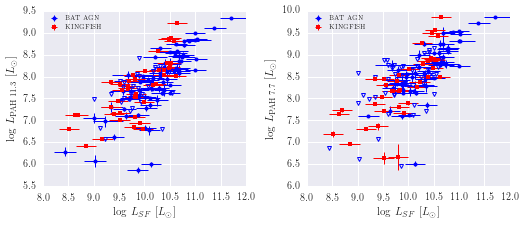

In [11]:
fig = plt.figure(figsize=(1.2*textwidth,1.2*3./8.*textwidth))
ax1 = fig.add_subplot(121)
pah11_3_detected = (df_lum['PAH 11.3'] >= 0) & (df_lum['PAH 11.3'] > 3*df_lum['PAH 11.3 err'])
lsf_detected = df_lum['lsf_flag'] == 0
both_detected_pah11_3 = pah11_3_detected & lsf_detected
pah11_3_only = (pah11_3_detected) & (~lsf_detected)
lsf_only_pah11_3 = (~pah11_3_detected) & (lsf_detected)
neither_pah11_3 = (~pah11_3_detected) & (~lsf_detected)
ms = 4
ax1.errorbar(df_lum['lsf'][both_detected_pah11_3], np.log10(df_lum['PAH 11.3'][both_detected_pah11_3]/3.846e33),
            xerr=np.vstack([df_lum['lsf_err_upper'][both_detected_pah11_3], df_lum['lsf_err_lower'][both_detected_pah11_3]]),
            yerr=0.434*df_lum['PAH 11.3 err'][both_detected_pah11_3]/df_lum['PAH 11.3'][both_detected_pah11_3], fmt='o',
            ls='None', color='b', label='BAT AGN', ms=ms, lw=1.0)
#ax1.plot(df_lum['lsf'][pah11_3_only], np.log10(df_lum['PAH 11.3'][pah11_3_only]/3.846e33),
#        marker='<', ms=ms, label='_nolabel', mfc='None', mec='b', ls='None', mew=1.0)
ax1.plot(df_lum['lsf'][lsf_only_pah11_3], np.log10(3*df_lum['PAH 11.3 err'][lsf_only_pah11_3]/3.846e33),
        marker='v', ls='None', ms=ms, mfc='None', mec='b', mew=1.0, label='_nolabel')
#ax1.plot(df_lum['lsf'][neither_pah11_3], np.log10(3*df_lum['PAH 11.3 err'][neither_pah11_3]/3.846e33),
#        marker='o', ls='None', ms=ms, mfc='None', mec='b', mew=1.0, label='_nolabel')
ax1.errorbar(kf_pahfit['lsf'], np.log10(kf_pahfit['PAH 11.3 lum']/3.846e33),
             xerr=np.vstack([kf_pahfit['lsf_err_up'], kf_pahfit['lsf_err_down']]),
             yerr=0.434*kf_pahfit['PAH 11.3 lum err']/kf_pahfit['PAH 11.3 lum'],
             color='r', fmt='s', ls='None', ms=ms, label='KINGFISH', lw=1.0)
ax1.set_xlabel('$\log\,L_{SF}$ [$L_{\odot}$]')
ax1.set_ylabel(r'$\log\,L_{\rm PAH\,11.3}$ [$L_{\odot}$]')

# Use the LPAH - LSF relation from Zakamska et al 2015 (based on work by Shi et al 2007)
# logLPAH_11.3 =  -0.7842 + 0.8759*log(LSF) both luminosities in solar luminosities
lsf = np.arange(7.5, 12.5, 0.001)
#lpah_zakam = -0.7842 + 0.8759*lsf
lpah11_3_bat_fit = 1.218*lsf - 4.6068
lpah11_3_kf_fit = 1.0185*lsf - 2.315
lpah11_3_shipley = ((lsf - np.log10(2.57e43) + np.log10(3.846e33)+44.14))/1.06 - np.log10(3.846e33)
#ax1.plot(lsf, lpah11_3_shipley, 'k-', label='Shipley+16')
#ax1.plot(xfit_11_3_bat, yfit_11_3_bat_median, 'b-')
#ax1.plot(xfit_11_3_bat, yfit_11_3_kf_median, 'r-')
#ax1.fill_between(xfit_11_3_bat, yfit_11_3_bat_lower95, yfit_11_3_bat_upper95, color='b', alpha=0.3)
#ax1.fill_between(xfit_11_3_bat, yfit_11_3_kf_lower95, yfit_11_3_kf_upper95, color='r', alpha=0.3)

ax1.set_ylim(5.5, 9.5)
ax1.set_xlim(7.5, 12.0)

# Use the LPAH - SFR relation from Diamond-Stanic et al 2012: SFR = 9.6e-9*LPAH_11.3
# Use the LIR - SFR relation from Murphy et al 2011: SFR = LSF/2.57e43
# LPAH_11.3 = LSF/2.57e43/9.2e-9 with LSF in ergs/s and LPAH_11.3 in Lsun
lpah_dms = np.log10(10**lsf*3.846e33/2.57e43/9.6e-9)
#ax1.plot(lsf, lpah_dms, 'r-', label='Diamond-Stanic+12')
ax1.legend(loc='upper left', fontsize=6)
ax1.set_xlim(8.0, 12.0)

pah7_7_detected = (df_lum['PAH 7.7'] > 0) & (df_lum['PAH 7.7'] > 3*df_lum['PAH 7.7 err'])
both_detected_pah7_7 = pah7_7_detected & lsf_detected
pah7_7_only = pah7_7_detected & ~lsf_detected
lsf_only_pah7_7 = ~pah7_7_detected & lsf_detected
neither_pah7_7 = ~pah7_7_detected & ~lsf_detected

ax2 = fig.add_subplot(122)
ax2.errorbar(df_lum['lsf'][both_detected_pah7_7], np.log10(df_lum['PAH 7.7'][both_detected_pah7_7]/3.846e33),
            xerr=np.vstack([df_lum['lsf_err_upper'][both_detected_pah7_7], df_lum['lsf_err_lower'][both_detected_pah7_7]]),
            yerr=0.434*df_lum['PAH 7.7 err'][both_detected_pah7_7]/df_lum['PAH 7.7'][both_detected_pah7_7], fmt='o',
            ls='None', color='b', label='BAT AGN', ms=ms, lw=1.0)
#ax2.plot(df_lum['lsf'][pah7_7_only], np.log10(df_lum['PAH 7.7'][pah7_7_only]/3.846e33),
#        marker='<', ms=ms, label='_nolabel', mfc='None', mec='b', ls='None', mew=1.0)
ax2.plot(df_lum['lsf'][lsf_only_pah7_7], np.log10(3*df_lum['PAH 7.7 err'][lsf_only_pah7_7]/3.846e33),
        marker='v', ls='None', ms=ms, mfc='None', mec='b', mew=1.0, label='_nolabel')
#ax2.plot(df_lum['lsf'][neither_pah7_7], np.log10(3*df_lum['PAH 7.7 err'][neither_pah7_7]/3.846e33),
#        marker='o', ls='None', ms=ms, mfc='None', mec='b', mew=1.0, label='_nolabel')
ax2.errorbar(kf_pahfit['lsf'], np.log10(kf_pahfit['PAH 7.7 lum']/3.846e33),
             xerr=np.vstack([kf_pahfit['lsf_err_up'], kf_pahfit['lsf_err_down']]),
             yerr=0.434*kf_pahfit['PAH 7.7 lum err']/kf_pahfit['PAH 7.7 lum'],
             color='r', fmt='s', ls='None', ms=ms, label='KINGFISH', lw=1.0)
ax2.set_xlabel('$\log\,L_{SF}$ [$L_{\odot}$]')
ax2.set_ylabel(r'$\log\,L_{\rm PAH\,7.7}$ [$L_{\odot}$]')
ax2.set_xlim(8.0, 12.0)
ax2.set_ylim(6, 10)
lsf = np.arange(7.5, 12.5, 0.001)
lpah7_bat = 1.15*lsf - 3.28
lpah7_kf = 1.108*lsf - 2.6387
lpah7 = np.log10(10**lsf*3.846e33/2.57e43/1.67e-9)
lpah7_v2 = 0.8195*lsf + 0.2372
lpah7_7_shipley = ((lsf - np.log10(2.57e43) + np.log10(3.846e33)+42.38)) - np.log10(3.846e33)
#ax2.plot(lsf, lpah7, 'r-', label='Roussel+01')
#ax2.plot(lsf, lpah7_7_shipley, 'k-', label='Shipley+16')
#ax2.plot(xfit_7_7_bat, yfit_7_7_bat_median, 'b-')
#ax2.plot(xfit_7_7_bat, yfit_7_7_kf_median, 'r-')
#ax2.fill_between(xfit_7_7_bat, yfit_7_7_bat_lower95, yfit_7_7_bat_upper95, color='b', alpha=0.3)
#ax2.fill_between(xfit_7_7_bat, yfit_7_7_kf_lower95, yfit_7_7_kf_upper95, color='r', alpha=0.3)
ax2.legend(loc='upper left', fontsize=6)
sn.despine()

fig.subplots_adjust(wspace=0.3)
#fig.savefig(figsave_dir+'lsf-vs-lpah.pdf', bbox_inches='tight')

In [12]:
x_pah11_3 = df_lum['lsf'][both_detected_pah11_3 | lsf_only_pah11_3]
y_pah11_3 = np.log10(df_lum['PAH 11.3'][both_detected_pah11_3 | lsf_only_pah11_3]/3.846e33)
y_pah11_3[lsf_only_pah11_3] = np.log10(3*df_lum['PAH 11.3 err'][lsf_only_pah11_3]/3.846e33)
xerr_pah11_3 = df_lum['lsf_err_upper'][both_detected_pah11_3 | lsf_only_pah11_3]
yerr_pah11_3 = 0.434*df_lum['PAH 11.3 err'][both_detected_pah11_3 | lsf_only_pah11_3]/df_lum['PAH 11.3'][both_detected_pah11_3 | lsf_only_pah11_3]
cens_pah11_3 = pd.Series(index=x_pah11_3.index)
cens_pah11_3[both_detected_pah11_3] = 1
cens_pah11_3[lsf_only_pah11_3] = 0

x_pah11_3 = x_pah11_3.drop(['CenA', 'M106'])
y_pah11_3 = y_pah11_3.drop(['CenA', 'M106'])
cens_pah11_3 = cens_pah11_3.drop(['CenA', 'M106'])
xerr_pah11_3 = xerr_pah11_3.drop(['CenA', 'M106'])
yerr_pah11_3 = yerr_pah11_3.drop(['CenA', 'M106'])

lm = linmix.LinMix(x=x_pah11_3.values, y=y_pah11_3.values, xsig=xerr_pah11_3.values, ysig=yerr_pah11_3.values,
                   delta=cens_pah11_3.values)
lm.run_mcmc(silent=True)

beta = np.median(lm.chain['beta'])
beta_err = np.std(lm.chain['beta'])
alpha = np.median(lm.chain['alpha'])
alpha_err = np.std(lm.chain['alpha'])
sigsqr = np.median(lm.chain['sigsqr'])
sigsqr_err = np.std(lm.chain['sigsqr'])
corr = np.median(lm.chain['corr'])
corr_err = np.std(lm.chain['corr'])

print 'beta =', beta, '+/-', beta_err
print 'alpha =', alpha, '+/-', alpha_err
print 'sigsqr =', sigsqr, '+/-', sigsqr_err
print 'corr =', corr, '+/-', corr_err

xfit_11_3_bat = np.arange(8.0, 12.0, 0.001)
yfit_11_3_bat = np.zeros((len(lm.chain['beta']), len(xfit_11_3_bat)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_11_3_bat[i, :] = alpha_i + beta_i*xfit_11_3_bat


yfit_11_3_bat_median = np.median(yfit_11_3_bat, axis=0)
yfit_11_3_bat_upper95 = np.percentile(yfit_11_3_bat, axis=0, q=97.5)
yfit_11_3_bat_lower95 = np.percentile(yfit_11_3_bat, axis=0, q=2.5)

beta = 1.2500520958 +/- 0.0950087540616
alpha = -4.96191915855 +/- 0.973268821166
sigsqr = 0.0758064248781 +/- 0.0255901839713
corr = 0.921542611963 +/- 0.0302589740688


In [13]:
xkf_pah11_3 = kf_pahfit['lsf']
ykf_pah11_3 = np.log10(kf_pahfit['PAH 11.3 lum']/3.846e33)
xkf_err_pah11_3 = kf_pahfit['lsf_err_up']
ykf_err_pah11_3 = 0.434*kf_pahfit['PAH 11.3 lum err']/kf_pahfit['PAH 11.3 lum']

lm = linmix.LinMix(x=xkf_pah11_3.values, y=ykf_pah11_3.values, xsig=xkf_err_pah11_3.values, ysig=ykf_err_pah11_3.values)
lm.run_mcmc(silent=True)

beta = np.median(lm.chain['beta'])
beta_err = np.std(lm.chain['beta'])
alpha = np.median(lm.chain['alpha'])
alpha_err = np.std(lm.chain['alpha'])
sigsqr = np.median(lm.chain['sigsqr'])
sigsqr_err = np.std(lm.chain['sigsqr'])
corr = np.median(lm.chain['corr'])
corr_err = np.std(lm.chain['corr'])

print 'beta =', beta, '+/-', beta_err
print 'alpha =', alpha, '+/-', alpha_err
print 'sigsqr =', sigsqr, '+/-', sigsqr_err
print 'corr =', corr, '+/-', corr_err

xfit_11_3_kf = np.arange(8.0, 12.0, 0.001)
yfit_11_3_kf = np.zeros((len(lm.chain['beta']), len(xfit_11_3_kf)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_11_3_kf[i, :] = alpha_i + beta_i*xfit_11_3_kf


yfit_11_3_kf_median = np.median(yfit_11_3_kf, axis=0)
yfit_11_3_kf_upper95 = np.percentile(yfit_11_3_kf, axis=0, q=97.5)
yfit_11_3_kf_lower95 = np.percentile(yfit_11_3_kf, axis=0, q=2.5)

beta = 1.02093688236 +/- 0.147352300688
alpha = -2.3391712737 +/- 1.45155881277
sigsqr = 0.159759195596 +/- 0.050009700978
corr = 0.819208288518 +/- 0.0749043362055


In [17]:
x_pah7_7 = df_lum['lsf'][both_detected_pah7_7 | lsf_only_pah7_7]
y_pah7_7 = np.log10(df_lum['PAH 7.7'][both_detected_pah7_7| lsf_only_pah7_7]/3.846e33)
y_pah7_7[lsf_only_pah7_7] = np.log10(3*df_lum['PAH 7.7 err'][lsf_only_pah7_7]/3.846e33)
xerr_pah7_7 = df_lum['lsf_err_upper'][both_detected_pah7_7 | lsf_only_pah7_7]
yerr_pah7_7 = 0.434*df_lum['PAH 7.7 err'][both_detected_pah7_7 | lsf_only_pah7_7]/df_lum['PAH 7.7'][both_detected_pah7_7 | lsf_only_pah7_7]
cens_pah7_7 = pd.Series(index=x_pah7_7.index)
cens_pah7_7[both_detected_pah7_7] = 1
cens_pah7_7[lsf_only_pah7_7] = 0

remove_srcs = ['CenA', 'M106']
x_pah7_7 = x_pah7_7.drop(remove_srcs)
y_pah7_7 = y_pah7_7.drop(remove_srcs)
cens_pah7_7 = cens_pah7_7.drop(remove_srcs)
xerr_pah7_7 = xerr_pah7_7.drop(remove_srcs)
yerr_pah7_7 = yerr_pah7_7.drop(remove_srcs)

lm = linmix.LinMix(x=x_pah7_7.values, y=y_pah7_7.values, xsig=xerr_pah7_7.values, ysig=yerr_pah7_7.values, delta=cens_pah7_7.values)
lm.run_mcmc(silent=True)

beta = np.median(lm.chain['beta'])
beta_err = np.std(lm.chain['beta'])
alpha = np.median(lm.chain['alpha'])
alpha_err = np.std(lm.chain['alpha'])
sigsqr = np.median(lm.chain['sigsqr'])
sigsqr_err = np.std(lm.chain['sigsqr'])
corr = np.median(lm.chain['corr'])
corr_err = np.std(lm.chain['corr'])

print 'beta =', beta, '+/-', beta_err
print 'alpha =', alpha, '+/-', alpha_err
print 'sigsqr =', sigsqr, '+/-', sigsqr_err
print 'corr =', corr, '+/-', corr_err

xfit_7_7_bat = np.arange(8.0, 12.0, 0.001)
yfit_7_7_bat = np.zeros((len(lm.chain['beta']), len(xfit_7_7_bat)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_7_7_bat[i, :] = alpha_i + beta_i*xfit_7_7_bat


yfit_7_7_bat_median = np.median(yfit_7_7_bat, axis=0)
yfit_7_7_bat_upper95 = np.percentile(yfit_7_7_bat, axis=0, q=97.5)
yfit_7_7_bat_lower95 = np.percentile(yfit_7_7_bat, axis=0, q=2.5)

beta = 1.36465393875 +/- 0.127574977565
alpha = -5.59105142098 +/- 1.3163163007
sigsqr = 0.0741974882344 +/- 0.0314118622239
corr = 0.933943410702 +/- 0.0319736052913


In [18]:
xkf_pah7_7 = kf_pahfit['lsf']
ykf_pah7_7 = np.log10(kf_pahfit['PAH 7.7 lum']/3.846e33)
xkf_err_pah7_7 = kf_pahfit['lsf_err_up']
ykf_err_pah7_7 = 0.434*kf_pahfit['PAH 7.7 lum err']/kf_pahfit['PAH 7.7 lum']

xkf_pah7_7 = xkf_pah7_7.drop(['NGC1316', 'NGC2841'])
ykf_pah7_7 = ykf_pah7_7.drop(['NGC1316', 'NGC2841'])
xkf_err_pah7_7 = xkf_err_pah7_7.drop(['NGC1316', 'NGC2841'])
ykf_err_pah7_7 = ykf_err_pah7_7.drop(['NGC1316', 'NGC2841'])

lm = linmix.LinMix(x=xkf_pah7_7.values, y=ykf_pah7_7.values, xsig=xkf_err_pah7_7.values, ysig=ykf_err_pah7_7.values)
lm.run_mcmc(silent=True)

beta = np.median(lm.chain['beta'])
beta_err = np.std(lm.chain['beta'])
alpha = np.median(lm.chain['alpha'])
alpha_err = np.std(lm.chain['alpha'])
sigsqr = np.median(lm.chain['sigsqr'])
sigsqr_err = np.std(lm.chain['sigsqr'])
corr = np.median(lm.chain['corr'])
corr_err = np.std(lm.chain['corr'])

print 'beta =', beta, '+/-', beta_err
print 'alpha =', alpha, '+/-', alpha_err
print 'sigsqr =', sigsqr, '+/-', sigsqr_err
print 'corr =', corr, '+/-', corr_err

xfit_7_7_kf = np.arange(8.0, 12.0, 0.001)
yfit_7_7_kf = np.zeros((len(lm.chain['beta']), len(xfit_7_7_kf)))

for i in range(len(lm.chain['beta'])):
    beta_i = lm.chain['beta'][i]
    alpha_i = lm.chain['alpha'][i]
    yfit_7_7_kf[i, :] = alpha_i + beta_i*xfit_7_7_kf


yfit_7_7_kf_median = np.median(yfit_7_7_kf, axis=0)
yfit_7_7_kf_upper95 = np.percentile(yfit_7_7_kf, axis=0, q=97.5)
yfit_7_7_kf_lower95 = np.percentile(yfit_7_7_kf, axis=0, q=2.5)

beta = 1.10626521387 +/- 0.160200380125
alpha = -2.61131348125 +/- 1.58038529024
sigsqr = 0.199747831937 +/- 0.0676593653064
corr = 0.817036814527 +/- 0.076589372635


In [21]:
len(x_pah7_7)

104